In [47]:
# Load the CIFAR-10 dataset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

In [48]:
# Split the data between the test and training sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)


Verify if the data is loaded correctly by loading and plotting the first image of every class

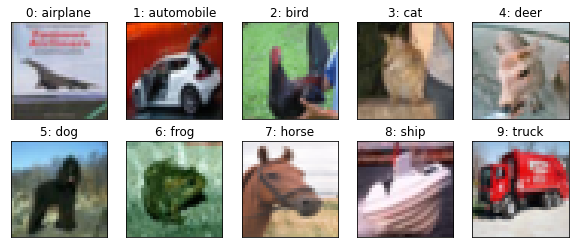

In [49]:
import matplotlib.pyplot as plt
import numpy as np

(_, _), (_, labels) = cifar10.load_data()
idx = [3, 6, 25, 46, 58, 85, 93, 99, 108, 133]

clsmap = {0: 'airplane',
          1: 'automobile',
          2: 'bird',
          3: 'cat',
          4: 'deer',
          5: 'dog',
          6: 'frog',
          7: 'horse',
          8: 'ship',
          9: 'truck', 
}

plt.figure(figsize=(10,4))
for i, (img, y) in enumerate(zip(x_test[idx].reshape(10, 32, 32, 3), labels[idx])):
  plt.subplot(2, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(str(y[0]) + ": " + clsmap[y[0]])
plt.show()


Compile the model

In [50]:
# Importing Keras libraries
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


Conv2D is a 2-dimentional convolution method. There are some common arguments used in a convolution layer.

1. filters it will refer to the number of the filters to be learned in this particular layer and affect the dimension of the output of the layer.


2. Kernel_size will refer to the size of the filter.


3. strides is defined as the size of the steps that are taken when the filters are sliding across the input. But in convolutional layers, we can take large step which lead to small outputs but also the loss of information.


4. padding='valid' it will refer to the way of dealing with the information in the edges of the convolution result. There are only 2 options which are valid or same and there are no way of achiving the full analytical result.


5. activation = None and it will give the option to include an activation function in the layer if we need one. (e.g. activation = 'relu')

In [51]:
# Dimensionality of input and latent encoded representation
inpt_dim = (32, 32, 3)
inpt_img = Input(shape=inpt_dim)

# Convolution layer
cl1 = Conv2D(64, (9,9), 
             strides=(2,2), 
             input_shape = inpt_dim, 
             activation = 'relu')(inpt_img)

# Pooling and BatchNorm
pl2 = MaxPool2D(pool_size = (2, 2))(cl1)
bnl3 = BatchNormalization()(pl2)

# 2nd Convolution layer
cl4 = Conv2D(128, (3,3), 
             strides=(1,1), 
             activation = 'relu')(bnl3)
pl5 = MaxPool2D(pool_size = (2, 2))(cl4)
bnl6 = BatchNormalization()(pl5)

# Flattening for compatibility
fl7 = Flatten()(bnl6)

# Dense layer + Dropout
dol8 = Dropout(0.5)(fl7)
dl9 = Dense(units = 256, activation = 'relu')(dol8)
dol10 = Dropout(0.5)(dl9)
dl11 = Dense(units = 64, activation = 'relu')(dol10)
dol12 = Dropout(0.5)(dl11)
output = Dense(units = 10, activation = 'sigmoid')(dol12)

classifier = Model(inpt_img, output)


In [52]:
# Compile the model and print a summary
# Compiling the CNN with RMSprop optimizer
opt = RMSprop(learning_rate=0.001)
classifier.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
print(classifier.summary())


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)        15616     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 2, 2, 128)       

In [53]:
# Train the model
# Fitting the CNN to the images
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=10, 
                              min_delta=1e-4, 
                              mode='min',
                              verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', 
                              patience=35, 
                              restore_best_weights=True,
                              verbose=1)

hist = classifier.fit(x_train, y_train, batch_size=100, epochs=1000, 
                      callbacks=[stop_alg, reduce_lr], 
                      shuffle=True, 
                      validation_data=(x_test, y_test))

classifier.save_weights('cnn.hdf5')



Epoch 1/1000
500/500 [==============================] - 13s 27ms/step - loss: 0.3582 - accuracy: 0.2205 - val_loss: 0.2885 - val_accuracy: 0.3265
Epoch 2/1000
500/500 [==============================] - 14s 27ms/step - loss: 0.2744 - accuracy: 0.3535 - val_loss: 0.2607 - val_accuracy: 0.3988
Epoch 3/1000
500/500 [==============================] - 14s 28ms/step - loss: 0.2502 - accuracy: 0.4228 - val_loss: 0.2238 - val_accuracy: 0.4818
Epoch 4/1000
500/500 [==============================] - 13s 27ms/step - loss: 0.2340 - accuracy: 0.4726 - val_loss: 0.2453 - val_accuracy: 0.4398
Epoch 5/1000
500/500 [==============================] - 13s 26ms/step - loss: 0.2229 - accuracy: 0.5001 - val_loss: 0.2230 - val_accuracy: 0.4925
Epoch 6/1000
500/500 [==============================] - 13s 26ms/step - loss: 0.2154 - accuracy: 0.5238 - val_loss: 0.1850 - val_accuracy: 0.5956
Epoch 7/1000
500/500 [==============================] - 14s 27ms/step - loss: 0.2096 - accuracy: 0.5412 - val_loss: 0.2378 -

500/500 [==============================] - 12s 24ms/step - loss: 0.1411 - accuracy: 0.7223 - val_loss: 0.1482 - val_accuracy: 0.6989
Epoch 56/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1415 - accuracy: 0.7233 - val_loss: 0.1473 - val_accuracy: 0.6951
Epoch 57/1000
500/500 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.7277
Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
500/500 [==============================] - 12s 25ms/step - loss: 0.1393 - accuracy: 0.7277 - val_loss: 0.1488 - val_accuracy: 0.7022
Epoch 58/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1354 - accuracy: 0.7345 - val_loss: 0.1413 - val_accuracy: 0.7115
Epoch 59/1000
500/500 [==============================] - 12s 24ms/step - loss: 0.1349 - accuracy: 0.7354 - val_loss: 0.1407 - val_accuracy: 0.7179
Epoch 60/1000
500/500 [==============================] - 12s 24ms/step - loss: 0.1347 - accuracy: 0.7339 - val_los

Epoch 107/1000
500/500 [==============================] - 12s 24ms/step - loss: 0.1244 - accuracy: 0.7578 - val_loss: 0.1311 - val_accuracy: 0.7419
Epoch 108/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1248 - accuracy: 0.7561 - val_loss: 0.1309 - val_accuracy: 0.7405
Epoch 109/1000
500/500 [==============================] - 13s 25ms/step - loss: 0.1244 - accuracy: 0.7579 - val_loss: 0.1310 - val_accuracy: 0.7435
Epoch 110/1000
500/500 [==============================] - 13s 25ms/step - loss: 0.1246 - accuracy: 0.7553 - val_loss: 0.1314 - val_accuracy: 0.7425
Epoch 111/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1244 - accuracy: 0.7585 - val_loss: 0.1315 - val_accuracy: 0.7423
Epoch 112/1000
500/500 [==============================] - 12s 24ms/step - loss: 0.1246 - accuracy: 0.7586 - val_loss: 0.1312 - val_accuracy: 0.7411
Epoch 113/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1248 - accuracy: 0.7577 - val_

500/500 [==============================] - 12s 25ms/step - loss: 0.1227 - accuracy: 0.7634 - val_loss: 0.1307 - val_accuracy: 0.7432
Epoch 160/1000
500/500 [==============================] - 13s 25ms/step - loss: 0.1234 - accuracy: 0.7591 - val_loss: 0.1306 - val_accuracy: 0.7431
Epoch 161/1000
500/500 [==============================] - 13s 25ms/step - loss: 0.1233 - accuracy: 0.7591 - val_loss: 0.1306 - val_accuracy: 0.7438
Epoch 162/1000
500/500 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.7612
Epoch 00162: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
500/500 [==============================] - 12s 25ms/step - loss: 0.1239 - accuracy: 0.7612 - val_loss: 0.1306 - val_accuracy: 0.7441
Epoch 163/1000
500/500 [==============================] - 12s 24ms/step - loss: 0.1232 - accuracy: 0.7595 - val_loss: 0.1305 - val_accuracy: 0.7443
Epoch 164/1000
500/500 [==============================] - 12s 25ms/step - loss: 0.1233 - accuracy: 0.7612 - v

When the training is finished, we can get an testimate of the accuracy of 79.68%. But be careful, this is not a balanced accuracy. So the method that we will use is Balanced Error Rate (BER) metric.

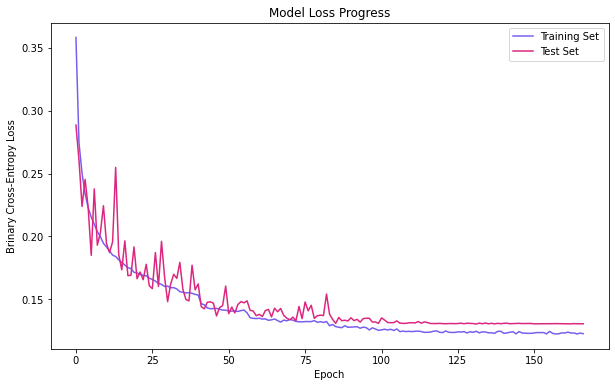

In [57]:
# Training curve
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Brinary Cross-Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()


From the above diagram we can see the bumps that the learning curve has, particularly visible on the training set curve which are due to the reduciton in the learning rate through the callback function, ReduceLROnPlateau. The training stops after the loss no longer improves on the test set, thanks to the EarlyStopping callback

In [58]:
# It is a time to look at objective, numerical results
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
 
(_, _), (_, labels) = cifar10.load_data()
 
y_ = labels
y_hat = classifier.predict(x_test)
y_pred = np.argmax(y_hat, axis=1)
 
print(classification_report(np.argmax(y_test, axis=1),
                           np.argmax(y_hat, axis=1),
                           labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
cm = confusion_matrix(np.argmax(y_test, axis=1),
                     np.argmax(y_hat, axis=1),
                     labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(cm)
ber = 1- balanced_accuracy_score(np.argmax(y_test, axis=1),
                                np.argmax(y_hat, axis=1))
print('BER', ber)


              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1000
           1       0.90      0.84      0.87      1000
           2       0.72      0.61      0.66      1000
           3       0.47      0.65      0.54      1000
           4       0.69      0.73      0.71      1000
           5       0.70      0.55      0.61      1000
           6       0.83      0.80      0.81      1000
           7       0.82      0.75      0.78      1000
           8       0.86      0.86      0.86      1000
           9       0.78      0.84      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.75     10000
weighted avg       0.75      0.74      0.75     10000

[[789  11  34  28  18   3   8   7  62  40]
 [ 23 840   2  14   2   1   9   1  21  87]
 [ 65   4 613 101  83  45  45  23  11  10]
 [ 14   5  54 650  57 115  48  29   7  21]
 [ 23   1  40  94 727  17  32  50   8   8]
 [  8   1  43 290  49 550 

Accuracy for specific classes can be high as 90% while the lowest accuracy is 47%. The BER is of 0.2572 which can all be interpreted as a balance of 74. This matches the accuracy reproted in the test set during training, which indicates that the model was trained properly.

Perform the Visualizations of filters

Visualization of the learned filters can be usefu if we want to do research on what the network is learning. But the deeper network will be more complicated to get to understand it.

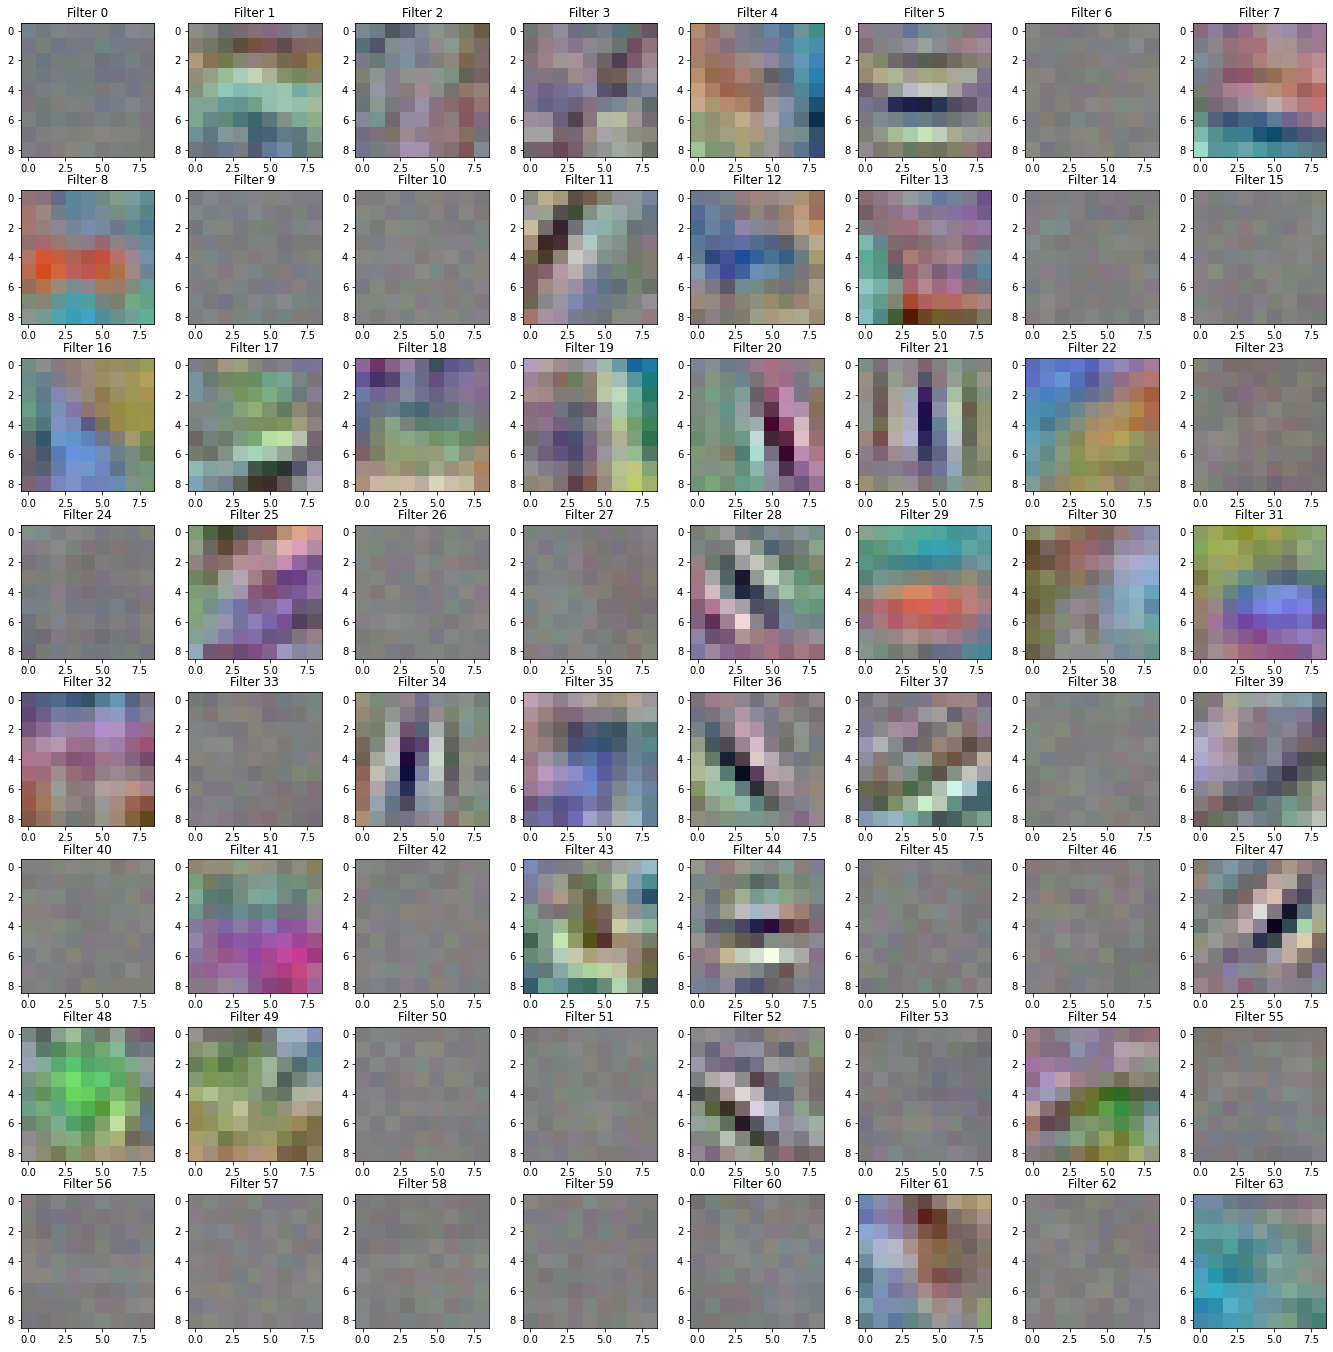

In [60]:
from sklearn.preprocessing import MinMaxScaler
cnnl1 = classifier.layers[1].name # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0] # gets the filters
wshape = W.shape # save the original shape

# The below part will scale to [0,1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

# Because we have 64 filters we will display them 8x8
fig,axs = plt.subplots(8,8, figsize=(24,24))
fig.subplots_adjust(hspace = 0.25, wspace = 0.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
    # We reshape to a 3D (RGB) image shape and display
    h = np.reshape(W[:,:,:,i],(9,9,3))
    axs[i].imshow(h)
    axs[i].set_title('Filter ' + str(i))
    

The above code will rely heavily on knowing which layer we want to visualize, the number of filter we want to visualize and the size of the filters themselves. In this project we want to visualize the first convolutional layer. It has 64 layers which is displayed in an 8x8 grid and each filter is 9x9x3 because the input is color images.